# Comparison to other Libraries

This notebook compares `halox` implementations against the [`colossus`](https://bdiemer.bitbucket.io/colossus/index.html) and [`gala`](https://gala.adrian.pw/en/latest/) libraries to validate the accuracy of our calculations.
Each comparison illustrate how to use `halox` to compute properties that are also present in `colossus`, and shows the agreement between the two libraries and their relative differences.

**Note:** These comparison are implemented as unit tests in the GitHub repository; see [Tests workflow](https://github.com/fkeruzore/halox/actions/workflows/tests.yml).

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# halox imports
from halox import cosmology, nfw, hmf, lss, bias, einasto

# colossus imports
from colossus.halo import profile_nfw, profile_einasto, mass_defs
from colossus.lss import mass_function, peaks, bias as colossus_bias
import colossus.cosmology.cosmology as cc
from colossus.utils.constants import G as Gcol

# gala for potentials
import gala.potential.potential as gp
from gala.units import galactic

print(Gcol)

jax.config.update("jax_enable_x64", True)  # double precision is, th

print(plt.style.available)
plt.style.use(["seaborn-v0_8-darkgrid", "petroff10"])
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

4.300917270038e-06
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'cmap-cividis', 'cmap-inferno', 'cmap-magma', 'cmap-plasma', 'cmap-viridis', 'colors10', 'colors10-ls', 'colors10-markers', 'colors5', 'colors5-light', 'colorsblind10', 'colorsblind34', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'ipynb', 'ls5', 'marker7', 'nature', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'svg_no_fonttype', 'tableau-colorblind10', 'use_mathtext', 'use_tex']


We'll use a consistent cosmology for both libraries:

In [2]:
# Setup cosmologies for both libraries
# Primary cosmology: Planck18
cosmo_halox_planck = cosmology.Planck18()
cc.addCosmology(  # not taking base planck18 because it differs sightly
    "my_planck18",
    params={
        "flat": True,
        "H0": 100 * cosmo_halox_planck.h,
        "Om0": cosmo_halox_planck.Omega_m,
        "Ob0": cosmo_halox_planck.Omega_b,
        "sigma8": cosmo_halox_planck.sigma8,
        "ns": cosmo_halox_planck.n_s,
    },
)
cosmo_colossus_planck = "my_planck18"

# Alternative cosmology: Flamingo's LS8
cosmo_halox_alt = cosmology.Planck18(
    h=0.682,
    Omega_c=0.305 - 0.0473,
    Omega_b=0.0473,
    sigma8=0.76,
    n_s=0.965,
)

cc.setCosmology(cosmo_colossus_planck)
cc.addCosmology(
    "low_s8",
    params={
        "flat": True,
        "H0": 100 * cosmo_halox_alt.h,
        "Om0": cosmo_halox_alt.Omega_m,
        "Ob0": cosmo_halox_alt.Omega_b,
        "sigma8": cosmo_halox_alt.sigma8,
        "ns": cosmo_halox_alt.n_s,
    },
)
cosmo_colossus_alt = "low_s8"

In [3]:
def create_comparison_plot():
    fig = plt.figure(figsize=(7.7, 5.5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.05)
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)

    # Remove x-axis labels from main panel
    ax_main.tick_params(labelbottom=False)

    # Style both panels
    for ax in [ax_main, ax_ratio]:
        ax.xaxis.set_ticks_position("both")
        ax.yaxis.set_ticks_position("both")
        ax.grid(True, alpha=1.0)

    return fig, ax_main, ax_ratio


style_kw = [
    dict(color="C1", ls="-", lw=1.5, zorder=1),
    dict(color="C0", ls="--", lw=2.5, zorder=2),
    dict(color="C3", ls="-", lw=1.5, zorder=1),
    dict(color="C2", ls="--", lw=2.5, zorder=2),
    dict(color="C5", ls="-", lw=1.5, zorder=1),
    dict(color="C4", ls=":", lw=2.5, zorder=2),
    dict(color="C0", ls="-", lw=2.5, zorder=2),
    dict(color="C2", ls="-", lw=2.5, zorder=2),
    dict(color="C4", ls=":", lw=2.5, zorder=2),
]

## NFW Profile Comparisons

### NFW Density Profile

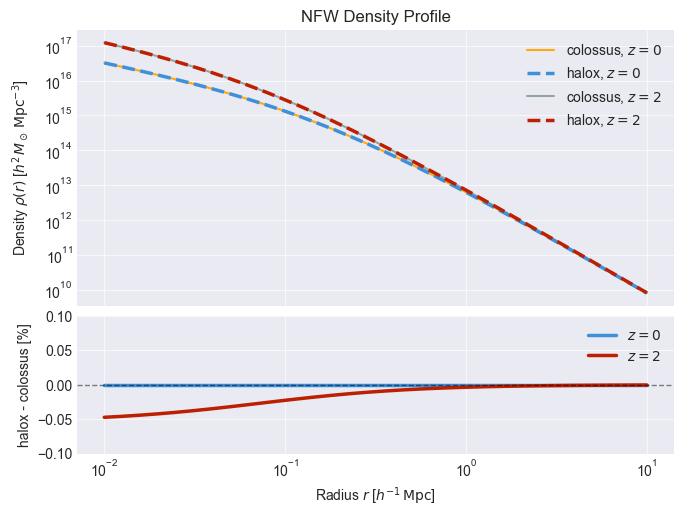

In [4]:
# Halo parameters
m_delta = 1e14  # h-1 Msun
c_delta = 5.0
deltas = [200.0]
redshifts = [0.0, 2.0]

# Radial range
r = jnp.logspace(-2, 1, 32)  # h-1 Mpc

# Compute density profiles for both redshifts
rho_halox = {}
rho_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    rho_halox[z] = nfw_halox.density(r)
    rho_colossus[z] = nfw_colossus.density(r * 1000) * 1e9

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, rho_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, rho_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, rho_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, rho_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax_main.set_title("NFW Density Profile")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (rho_halox[0.0] / rho_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (rho_halox[2.0] / rho_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### NFW Enclosed Mass

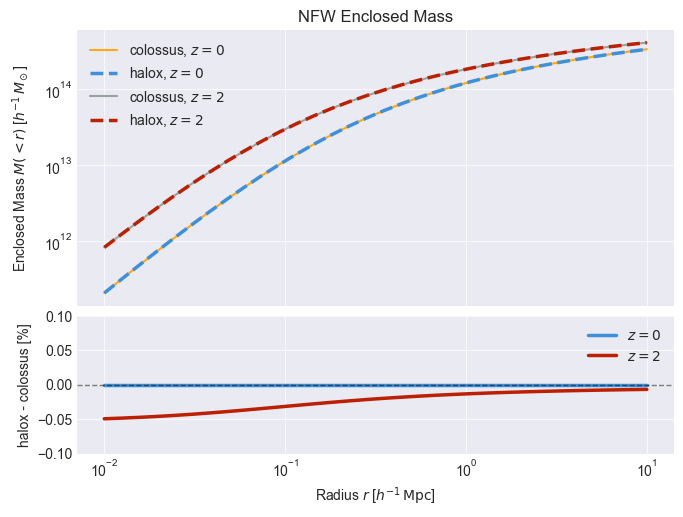

In [5]:
# Compute enclosed mass profiles for both redshifts
mass_halox = {}
mass_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    mass_halox[z] = nfw_halox.enclosed_mass(r)
    mass_colossus[z] = nfw_colossus.enclosedMass(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, mass_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, mass_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, mass_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, mass_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax_main.set_title("NFW Enclosed Mass")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (mass_halox[0.0] / mass_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (mass_halox[2.0] / mass_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### NFW Surface Density

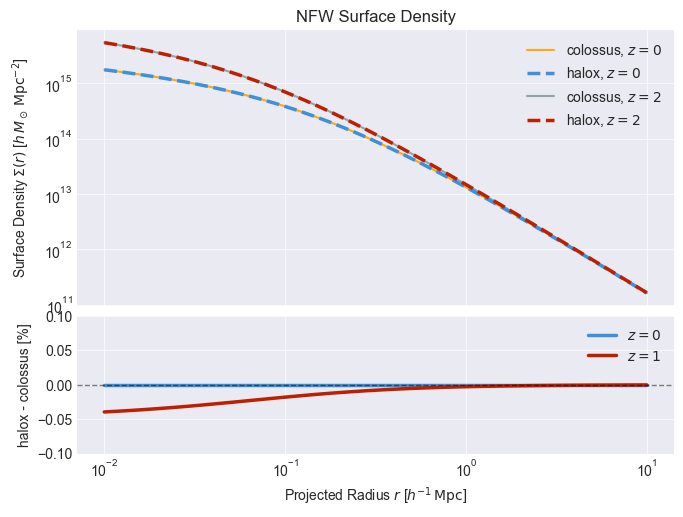

In [6]:
# Compute surface density profiles for both redshifts
sigma_surf_halox = {}
sigma_surf_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    sigma_surf_halox[z] = nfw_halox.surface_density(r)
    sigma_surf_colossus[z] = nfw_colossus.surfaceDensity(r * 1000) * 1e6

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    r, sigma_surf_colossus[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(r, sigma_surf_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(
    r, sigma_surf_colossus[2.0], label="colossus, $z=2$", **style_kw[2]
)
ax_main.loglog(r, sigma_surf_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(
    r"Surface Density $\Sigma(r)$ [$h \, M_\odot \, {\rm Mpc}^{-2}$]"
)
ax_main.set_title("NFW Surface Density")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (
    sigma_surf_halox[0.0] / sigma_surf_colossus[0.0] - 1.0
) * 100  # Convert to %
ratio_z1 = (
    sigma_surf_halox[2.0] / sigma_surf_colossus[2.0] - 1.0
) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Projected Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### NFW Circular Velocity

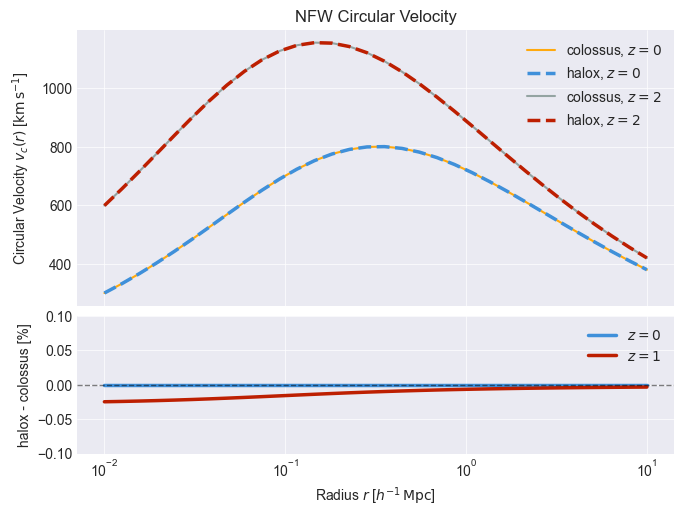

In [7]:
# Compute circular velocity profiles for both redshifts
v_c_halox = {}
v_c_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    v_c_halox[z] = nfw_halox.circular_velocity(r)
    v_c_colossus[z] = nfw_colossus.circularVelocity(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, v_c_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.semilogx(r, v_c_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.semilogx(r, v_c_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.semilogx(r, v_c_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Circular Velocity $v_c(r)$ [${\rm km} \, {\rm s}^{-1}$]")
ax_main.set_title("NFW Circular Velocity")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (v_c_halox[0.0] / v_c_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (v_c_halox[2.0] / v_c_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### NFW Potential

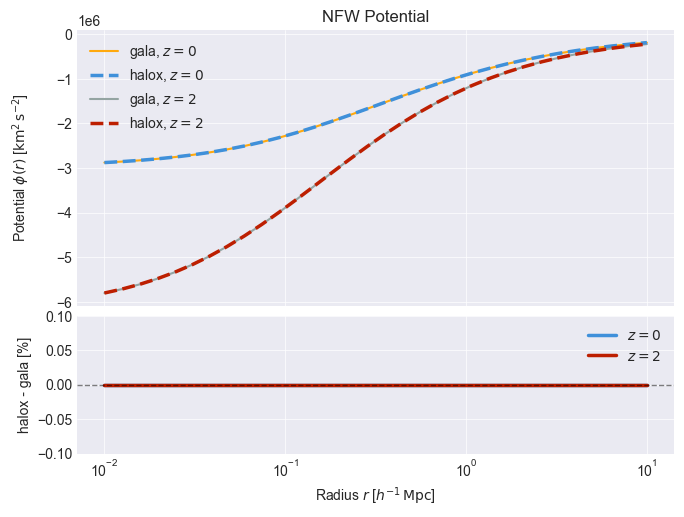

In [8]:
import astropy.units as u
import numpy as np

phi_gala = {}
phi_halox = {}

kmperkpc = 30856775999999956
secpermyr = 3.15576e13
confactor = kmperkpc**2 / secpermyr**2
# print(confactor) #conversion from kpc^2 per Myr^2 to km^2 per s^2

for z in redshifts:
    haloxhalo = nfw.NFWHalo(m_delta, c_delta, z, cosmo_halox_planck)
    m = (m_delta / (np.log(1 + c_delta) - c_delta / (1 + c_delta))) * u.Msun
    r_s = (
        haloxhalo.r_delta * 1000 / c_delta * u.kpc
    )  # converting r_delta to kpc
    galahalo = gp.NFWPotential(m=m, r_s=r_s, units=galactic)

    r_kpc = r * 1000 * u.kpc  # if r was in Mpc
    xyz = np.zeros((3, len(r_kpc))) * u.kpc
    xyz[0] = r_kpc
    phi_halox[z] = haloxhalo.potential(r)
    phi_gala[z] = galahalo.energy(xyz).value * confactor

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, phi_gala[0.0], label="gala, $z=0$", **style_kw[0])
ax_main.semilogx(r, phi_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.semilogx(r, phi_gala[2.0], label="gala, $z=2$", **style_kw[2])
ax_main.semilogx(r, phi_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Potential $\phi(r)$ [${\rm km^2} \, {\rm s}^{-2}$]")
ax_main.set_title("NFW Potential")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (phi_halox[0.0] / phi_gala[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (phi_halox[2.0] / phi_gala[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - gala [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

# Einasto Profile Comparisons

### Einasto Density Profile

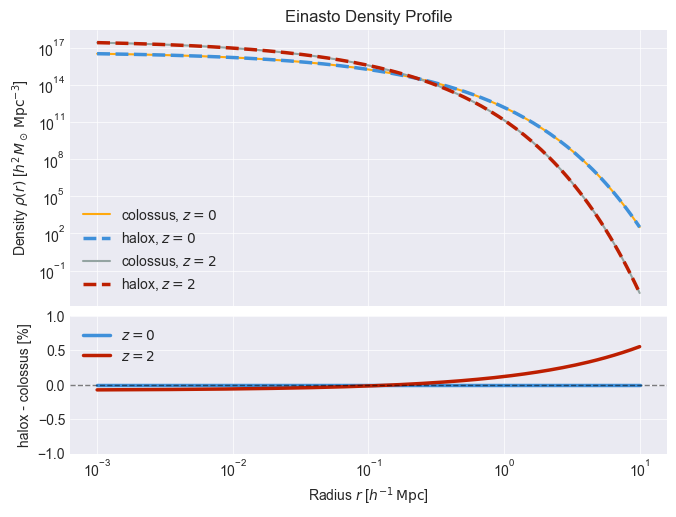

In [15]:
# Halo parameters
m_delta = 1e14  # h-1 Msun
c_delta = 5.0
alpha = 0.5
deltas = [200.0]
redshifts = [0.0, 2.0]

# Radial range
r = jnp.logspace(-3, 1, 128)  # h-1 Mpc

# Compute density profiles for both redshifts
rho_halox = {}
rho_colossus = {}
for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, z, alpha, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha=alpha
    )

    rho_halox[z] = einasto_halox.density(r)
    rho_colossus[z] = einasto_colossus.density(r * 1000) * 1e9

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, rho_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, rho_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=1.0
ax_main.loglog(r, rho_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, rho_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax_main.set_title("Einasto Density Profile")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (rho_halox[0.0] / rho_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (rho_halox[2.0] / rho_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-1, 1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Einasto Enclosed Mass

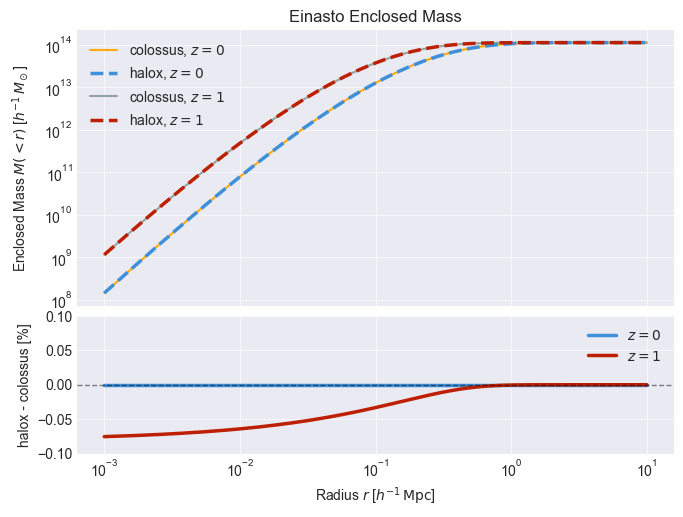

In [11]:
# Compute enclosed mass profiles for both redshifts
mass_halox = {}
mass_colossus = {}

for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, z, alpha, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha=alpha
    )

    mass_halox[z] = einasto_halox.enclosed_mass(r)
    mass_colossus[z] = einasto_colossus.enclosedMass(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, mass_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, mass_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, mass_colossus[2.0], label="colossus, $z=1$", **style_kw[2])
ax_main.loglog(r, mass_halox[2.0], label="halox, $z=1$", **style_kw[3])

ax_main.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax_main.set_title("Einasto Enclosed Mass")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (mass_halox[0.0] / mass_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (mass_halox[2.0] / mass_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Einasto Circular Velocity

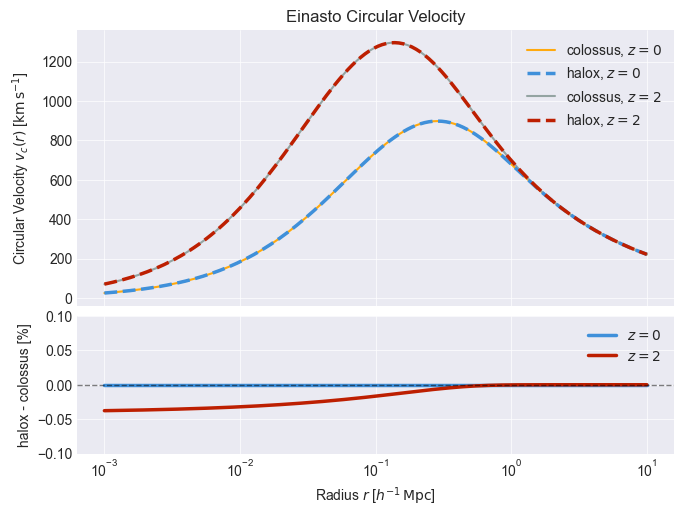

In [16]:
# Compute circular velocity profiles for both redshifts
v_c_halox = {}
v_c_colossus = {}

for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, z, alpha, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha=alpha
    )

    v_c_halox[z] = einasto_halox.circular_velocity(r)
    v_c_colossus[z] = einasto_colossus.circularVelocity(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, v_c_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.semilogx(r, v_c_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.semilogx(r, v_c_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.semilogx(r, v_c_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Circular Velocity $v_c(r)$ [${\rm km} \, {\rm s}^{-1}$]")
ax_main.set_title("Einasto Circular Velocity")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (v_c_halox[0.0] / v_c_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (v_c_halox[2.0] / v_c_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

## LSS and Halo Mass Function Comparisons

### RMS Variance σ(R,z)

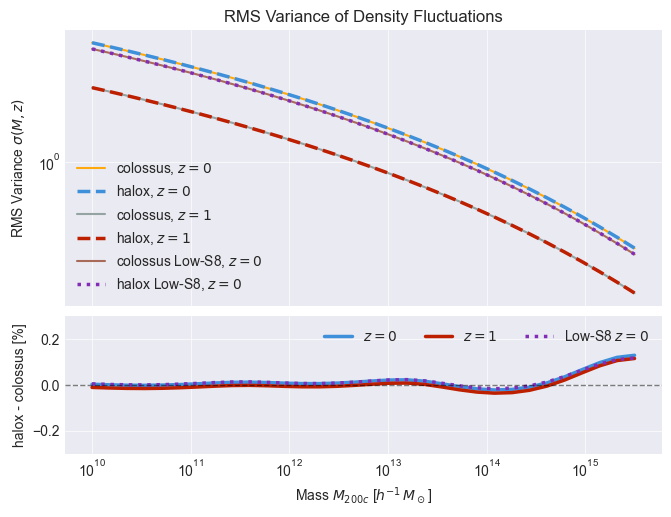

In [17]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]

# Compute sigma values for both redshifts and cosmologies
sigma_halox_planck = {}
sigma_halox_alt = {}
sigma_colossus_planck = {}
sigma_colossus_alt = {}


@jax.jit
def compute_sigma_halox(masses, z, cosmo):
    """JIT-compiled batch computation of sigma values"""
    R = lss.mass_to_lagrangian_radius(masses, cosmo)
    return lss.sigma_R(R, z, cosmo)


for z in redshifts:
    # Planck cosmology
    sigma_halox_planck[z] = compute_sigma_halox(masses, z, cosmo_halox_planck)
    cosmo_col_obj_planck = cc.setCosmology(cosmo_colossus_planck)
    sigma_colossus_planck[z] = cosmo_col_obj_planck.sigma(
        peaks.lagrangianR(masses), z=z
    )

    # Alternative cosmology
    sigma_halox_alt[z] = compute_sigma_halox(masses, z, cosmo_halox_alt)
    cosmo_col_obj_alt = cc.setCosmology(cosmo_colossus_alt)
    sigma_colossus_alt[z] = cosmo_col_obj_alt.sigma(
        peaks.lagrangianR(masses), z=z
    )

# Reset to Planck cosmology for subsequent cells
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses, sigma_colossus_planck[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(
    masses, sigma_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses, sigma_colossus_planck[1.0], label="colossus, $z=1$", **style_kw[2]
)
ax_main.loglog(
    masses, sigma_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    sigma_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, sigma_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"RMS Variance $\sigma(M,z)$")
ax_main.set_title("RMS Variance of Density Fluctuations")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    sigma_halox_planck[0.0] / sigma_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    sigma_halox_planck[1.0] / sigma_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (sigma_halox_alt[0.0] / sigma_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.3, 0.3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker08 Multiplicity Function f(σ)

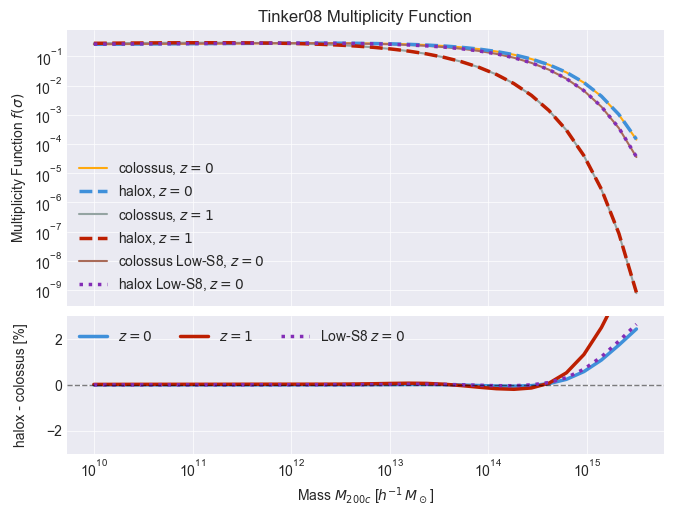

In [18]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled functions for f(sigma) computation
halox_compute_f_sigma = jax.jit(hmf.tinker08_f_sigma)

# Compute f(sigma) for both redshifts and cosmologies
f_sigma_halox_planck = {}
f_sigma_halox_alt = {}
f_sigma_colossus_planck = {}
f_sigma_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    f_sigma_halox_planck[z] = halox_compute_f_sigma(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    f_sigma_colossus_planck[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="f",
    )

    # Alternative cosmology
    f_sigma_halox_alt[z] = halox_compute_f_sigma(
        masses, z, cosmo_halox_alt, delta_c
    )
    cc.setCosmology(cosmo_colossus_alt)
    f_sigma_colossus_alt[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="f",
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses,
    f_sigma_colossus_planck[0.0],
    label="colossus, $z=0$",
    **style_kw[0],
)
ax_main.loglog(
    masses, f_sigma_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses,
    f_sigma_colossus_planck[1.0],
    label="colossus, $z=1$",
    **style_kw[2],
)
ax_main.loglog(
    masses, f_sigma_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    f_sigma_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, f_sigma_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"Multiplicity Function $f(\sigma)$")
ax_main.set_title("Tinker08 Multiplicity Function")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    f_sigma_halox_planck[0.0] / f_sigma_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    f_sigma_halox_planck[1.0] / f_sigma_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (f_sigma_halox_alt[0.0] / f_sigma_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-3, 3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker08 Mass Function dn/d ln M

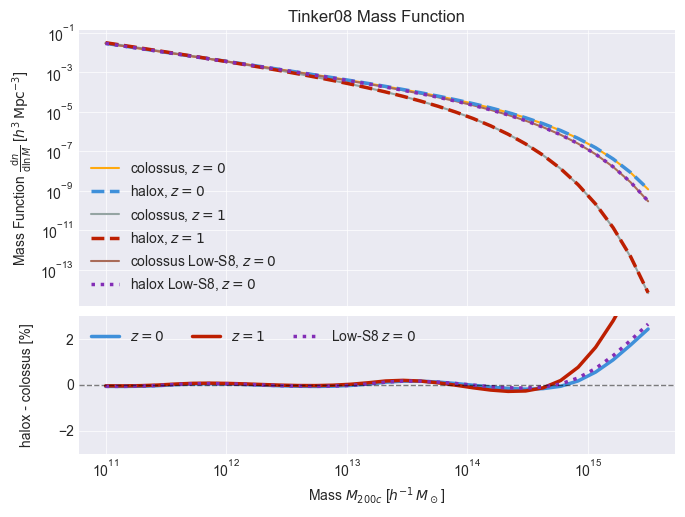

In [19]:
# Mass range and redshifts
masses = jnp.logspace(11, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled function for mass function computation
halox_compute_hmf = jax.jit(hmf.tinker08_mass_function)

# Compute mass functions for both redshifts and cosmologies
dn_dlnM_halox_planck = {}
dn_dlnM_halox_alt = {}
dn_dlnM_colossus_planck = {}
dn_dlnM_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    dn_dlnM_halox_planck[z] = halox_compute_hmf(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    dn_dlnM_colossus_planck[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="dndlnM",
    )

    # Alternative cosmology
    dn_dlnM_halox_alt[z] = halox_compute_hmf(
        masses, z, cosmo_halox_alt, delta_c
    )
    cc.setCosmology(cosmo_colossus_alt)
    dn_dlnM_colossus_alt[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="dndlnM",
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses,
    dn_dlnM_colossus_planck[0.0],
    label="colossus, $z=0$",
    **style_kw[0],
)
ax_main.loglog(
    masses, dn_dlnM_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses,
    dn_dlnM_colossus_planck[1.0],
    label="colossus, $z=1$",
    **style_kw[2],
)
ax_main.loglog(
    masses, dn_dlnM_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    dn_dlnM_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, dn_dlnM_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(
    r"Mass Function $\frac{{\rm d}n}{{\rm d}\ln M}$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax_main.set_title("Tinker08 Mass Function")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    dn_dlnM_halox_planck[0.0] / dn_dlnM_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    dn_dlnM_halox_planck[1.0] / dn_dlnM_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (dn_dlnM_halox_alt[0.0] / dn_dlnM_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-3, 3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker10 Halo Bias

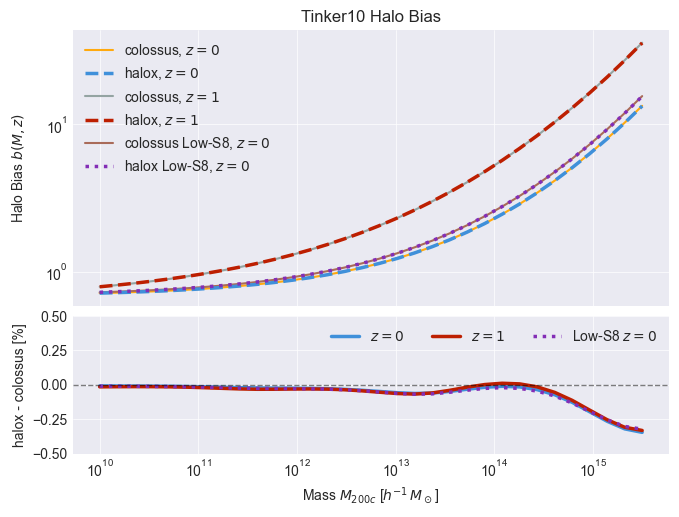

In [20]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled function for halo bias computation
halox_compute_bias = jax.jit(bias.tinker10_bias)

# Compute halo bias for both redshifts and cosmologies
bias_halox_planck = {}
bias_halox_alt = {}
bias_colossus_planck = {}
bias_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    bias_halox_planck[z] = halox_compute_bias(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    bias_colossus_planck[z] = colossus_bias.haloBias(
        masses, z, mdef=f"{delta_c:.0f}c", model="tinker10"
    )

    # Alternative cosmology
    bias_halox_alt[z] = halox_compute_bias(masses, z, cosmo_halox_alt, delta_c)
    cc.setCosmology(cosmo_colossus_alt)
    bias_colossus_alt[z] = colossus_bias.haloBias(
        masses, z, mdef=f"{delta_c:.0f}c", model="tinker10"
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses, bias_colossus_planck[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(
    masses, bias_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses, bias_colossus_planck[1.0], label="colossus, $z=1$", **style_kw[2]
)
ax_main.loglog(
    masses, bias_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    bias_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, bias_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"Halo Bias $b(M,z)$")
ax_main.set_title("Tinker10 Halo Bias")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    bias_halox_planck[0.0] / bias_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    bias_halox_planck[1.0] / bias_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (bias_halox_alt[0.0] / bias_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.5, 0.5)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])